In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score

In [22]:
#input data
data = pd.read_excel('IND.xlsx')
data.head()

,year,creditor,debtor,indicator,debt
0,1970,WLD,IND,DT.DOD.DECT.CD,8.425121e+09
1,1971,WLD,IND,DT.DOD.DECT.CD,9.328742e+09
2,1972,WLD,IND,DT.DOD.DECT.CD,1.002927e+10
3,1973,WLD,IND,DT.DOD.DECT.CD,1.096592e+10
4,1974,WLD,IND,DT.DOD.DECT.CD,1.269695e+10


In [23]:
# Check for missing values
print(data.isnull().sum())

year         0
creditor     0
debtor       0
indicator    0
debt         0
dtype: int64


Text(0.5, 1.0, 'Boxplot of Debt Amount')

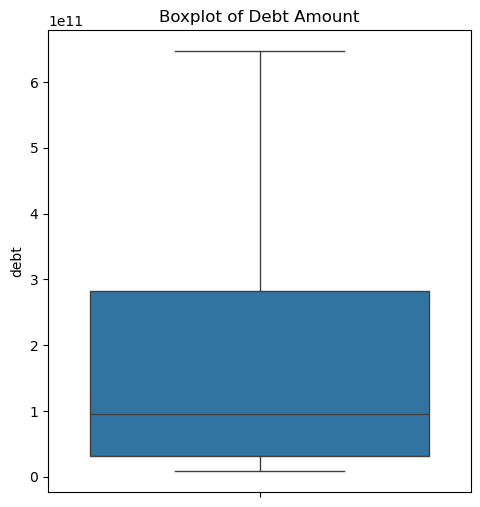

In [24]:
Q1 = data['debt'].quantile(0.25)
Q3 = data['debt'].quantile(0.75)
IQR = Q3 - Q1
df = data[~((data['debt'] < (Q1 - 1.5 * IQR)) | (data['debt'] > (Q3 + 1.5 * IQR)))]

# Plotting
plt.figure(figsize=(12, 6))

# Before removing outliers
plt.subplot(1, 2, 1)
sns.boxplot(data['debt'])
plt.title('Boxplot of Debt Amount')


In [25]:
# Check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

check_stationarity(data['debt'])

ADF Statistic: 1.0720995716448587
p-value: 0.9949713266569319
Critical Values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
Data is non-stationary


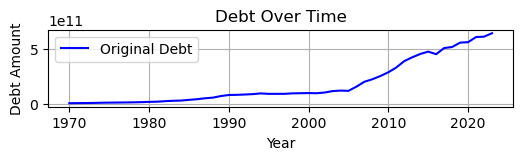

In [57]:
# Plot the original debt data with year on the x-axis
plt.figure(figsize=(6, 1))
plt.plot(data['year'], data['debt'], label='Original Debt', color='blue')
plt.title('Debt Over Time')
plt.xlabel('Year')
plt.ylabel('Debt Amount')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
data['debt_diff'] = data['debt'].diff().dropna()
check_stationarity(data['debt_diff'].dropna())

ADF Statistic: -2.2313730031037675
p-value: 0.19505650276199477
Critical Values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
Data is non-stationary


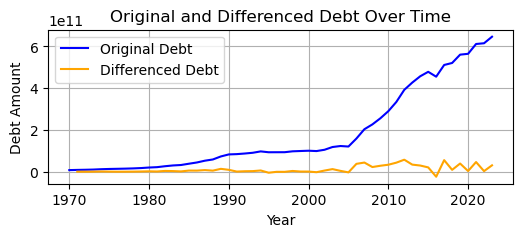

In [59]:
# Plot original and differenced data
plt.figure(figsize=(6,2))

# Original data
plt.plot(data['year'], data['debt'], label='Original Debt', color='blue')

# Differenced data (skip the first NaN value)
plt.plot(data['year'], data['debt_diff'], label='Differenced Debt', color='orange')

plt.title('Original and Differenced Debt Over Time')
plt.xlabel('Year')
plt.ylabel('Debt Amount')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
data['debt_diff2'] = data['debt'].diff().diff().dropna()
check_stationarity(data['debt_diff2'].dropna())

ADF Statistic: -6.5110573270311844
p-value: 1.1001567842049325e-08
Critical Values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Data is stationary


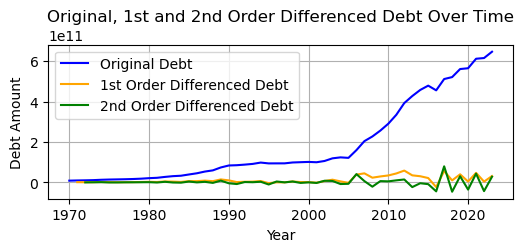

In [62]:
# Plot original, first-order differenced, and second-order differenced data
plt.figure(figsize=(6, 2))

# Original data
plt.plot(data['year'], data['debt'], label='Original Debt', color='blue')

# First-order differenced data
plt.plot(data['year'], data['debt_diff'], label='1st Order Differenced Debt', color='orange')

# Second-order differenced data
plt.plot(data['year'], data['debt_diff2'], label='2nd Order Differenced Debt', color='green')

plt.title('Original, 1st and 2nd Order Differenced Debt Over Time')
plt.xlabel('Year')
plt.ylabel('Debt Amount')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Step 4: ARIMA Model Selection Using AIC and BIC
def find_best_arima(data, max_p=3, max_d=2, max_q=3):
    results = []
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    results.append({
                        'Order': (p, d, q),
                        'AIC': model_fit.aic,
                        'BIC': model_fit.bic
                    })
                except:
                    continue
    results_df = pd.DataFrame(results)
    return results_df

# Find the best ARIMA model
results_df = find_best_arima(data['debt'])
print("ARIMA Model Comparison:")
print(results_df)

c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dhevi\anaconda3\Lib\s

ARIMA Model Comparison:
        Order          AIC          BIC
0   (0, 0, 0)  3128.182567  3132.160535
1   (0, 0, 1)  2932.584573  2938.551525
2   (0, 0, 2)  2925.545993  2933.501929
3   (0, 0, 3)  2926.471161  2936.416081
4   (0, 1, 0)  2671.772617  2673.742909
5   (0, 1, 1)  2667.071637  2671.012221
6   (0, 1, 2)  2656.248410  2662.159285
7   (0, 1, 3)  2659.483638  2667.364806
8   (0, 2, 0)  2616.750322  2618.701565
9   (0, 2, 1)  2588.884353  2592.786840
10  (0, 2, 2)  2588.968827  2594.822558
11  (0, 2, 3)  2590.117049  2597.922024
12  (1, 0, 0)  2732.423017  2738.389969
13  (1, 0, 1)  2725.962557  2733.918493
14  (1, 0, 2)  2712.444887  2722.389808
15  (1, 0, 3)  2715.227099  2727.161003
16  (1, 1, 0)  2655.368291  2659.308875
17  (1, 1, 1)  2639.986688  2645.897564
18  (1, 1, 2)  2639.373344  2647.254512
19  (1, 1, 3)  2641.220266  2651.071726
20  (1, 2, 0)  2584.342123  2588.244610
21  (1, 2, 1)  2584.232505  2590.086236
22  (1, 2, 2)  2583.403218  2591.208193
23  (1, 2, 3)  2

In [29]:
# Select the best model based on AIC
best_model_aic = results_df.loc[results_df['AIC'].idxmin()]
print("\nBest Model (AIC):")
print(best_model_aic)


Best Model (AIC):
Order      (3, 2, 0)
AIC       2583.12775
BIC      2590.932725
Name: 44, dtype: object


In [30]:
# Auto ARIMA to find best parameters
model = auto_arima(data['debt'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2587.285, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2618.669, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2586.278, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2591.858, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2616.750, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2587.710, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2586.037, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2587.078, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2585.284, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2591.704, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2588.133, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2594.723, Time=0.02 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2589.566, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2583.403, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]          

In [31]:
train, test = train_test_split(data['debt'], test_size=0.3, shuffle=False)

# Fit ARIMA model
model = ARIMA(train, order=(3, 2, 0))  # (p, d, q)
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:                   debt   No. Observations:                   37
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -840.059
Date:                Sun, 09 Mar 2025   AIC                           1688.119
Time:                        22:43:24   BIC                           1694.340
Sample:                             0   HQIC                          1690.266
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9433      0.312     -3.027      0.002      -1.554      -0.332
ar.L2         -1.0454      0.257     -4.068      0.000      -1.549      -0.542
ar.L3         -0.3651      0.416     -0.878      0.3

In [32]:
# Evaluate ARIMA model
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error (MAE): {mae}')
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
rmse = root_mean_squared_error(test, forecast)
print(f'Root Mean Squared Error (RMSE): {rmse}')
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test, forecast)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 171717050595.89902
Mean Squared Error (MSE): 3.4633980610307967e+22
Root Mean Squared Error (RMSE): 186102070408.44003
Mean Absolute Percentage Error (MAPE): 36.70780974724636%


In [33]:
train, test = train_test_split(data['debt'], test_size=0.3, shuffle=False)

# Fit ARIMA model
model = ARIMA(train, order=(1, 2, 2))  # (p, d, q)
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))

                               SARIMAX Results                                
Dep. Variable:                   debt   No. Observations:                   37
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -841.881
Date:                Sun, 09 Mar 2025   AIC                           1691.761
Time:                        22:43:26   BIC                           1697.983
Sample:                             0   HQIC                          1693.909
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0693      1.233     -0.056      0.955      -2.486       2.348
ma.L1         -1.1157      0.784     -1.423      0.155      -2.653       0.421
ma.L2          0.7160      0.755      0.948      0.3

In [34]:
# Evaluate ARIMA model
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error (MAE): {mae}')
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
rmse = root_mean_squared_error(test, forecast)
print(f'Root Mean Squared Error (RMSE): {rmse}')
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test, forecast)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 127845439563.31987
Mean Squared Error (MSE): 1.8429813685457154e+22
Root Mean Squared Error (RMSE): 135756449885.28963
Mean Absolute Percentage Error (MAPE): 28.121162987583865%


In [35]:
# Fit the ARIMA model
model = ARIMA(data['debt'], order=(1, 2, 2))  # Adjust (p, d, q) as needed
model_fit = model.fit()

In [36]:
# Predict the debt for the original years
data['Predicted_Debt'] = model_fit.predict(start=0, end=len(df) - 1, typ='levels')
data['residual']=data['debt']-data['Predicted_Debt']

In [42]:
# Reset the index to include 'Year' as a column
data.reset_index(inplace=True)

# Select the columns you want to display
result_df = data[['year', 'debt', 'Predicted_Debt','residual']]

# Print the DataFrame
print(result_df)

    year          debt  Predicted_Debt      residual
0   1970  8.425121e+09    0.000000e+00  8.425121e+09
1   1971  9.328742e+09    1.049996e+10 -1.171220e+09
2   1972  1.002927e+10    1.566090e+10 -5.631635e+09
3   1973  1.096592e+10    1.091109e+10  5.483249e+07
4   1974  1.269695e+10    1.389676e+10 -1.199805e+09
5   1975  1.386561e+10    1.357552e+10  2.900898e+08
6   1976  1.458639e+10    1.609065e+10 -1.504255e+09
7   1977  1.541466e+10    1.547882e+10 -6.416577e+07
8   1978  1.652025e+10    1.679056e+10 -2.703145e+08
9   1979  1.819038e+10    1.737548e+10  8.149018e+08
10  1980  2.072336e+10    1.951908e+10  1.204277e+09
11  1981  2.248007e+10    2.219707e+10  2.830042e+08
12  1982  2.694286e+10    2.445447e+10  2.488391e+09
13  1983  3.064949e+10    2.897096e+10  1.678533e+09
14  1984  3.276396e+10    3.410636e+10 -1.342397e+09
15  1985  3.893481e+10    3.551758e+10  3.417232e+09
16  1986  4.490944e+10    4.220025e+10  2.709192e+09
17  1987  5.342490e+10    4.979246e+10  3.6324

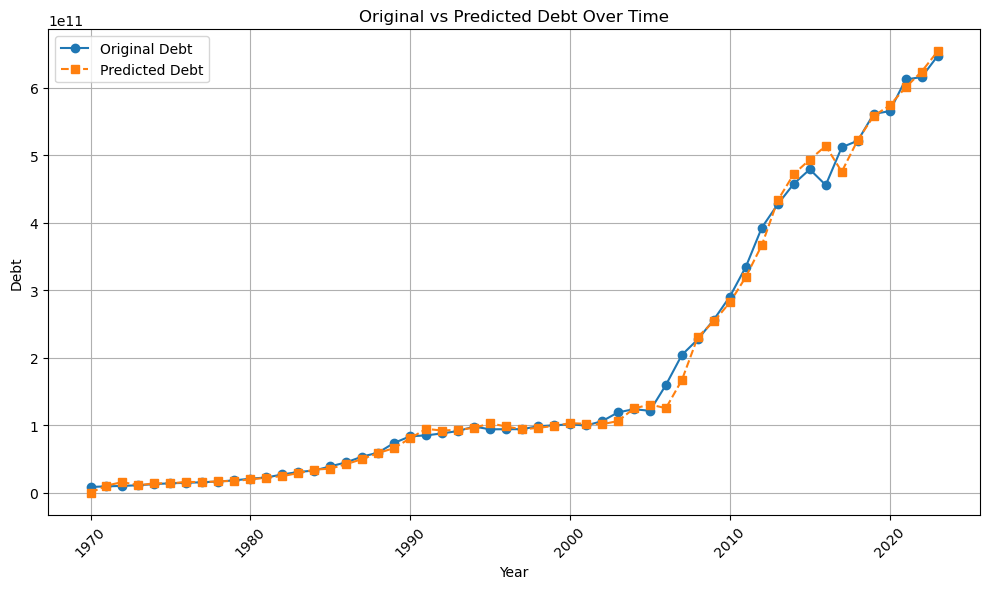

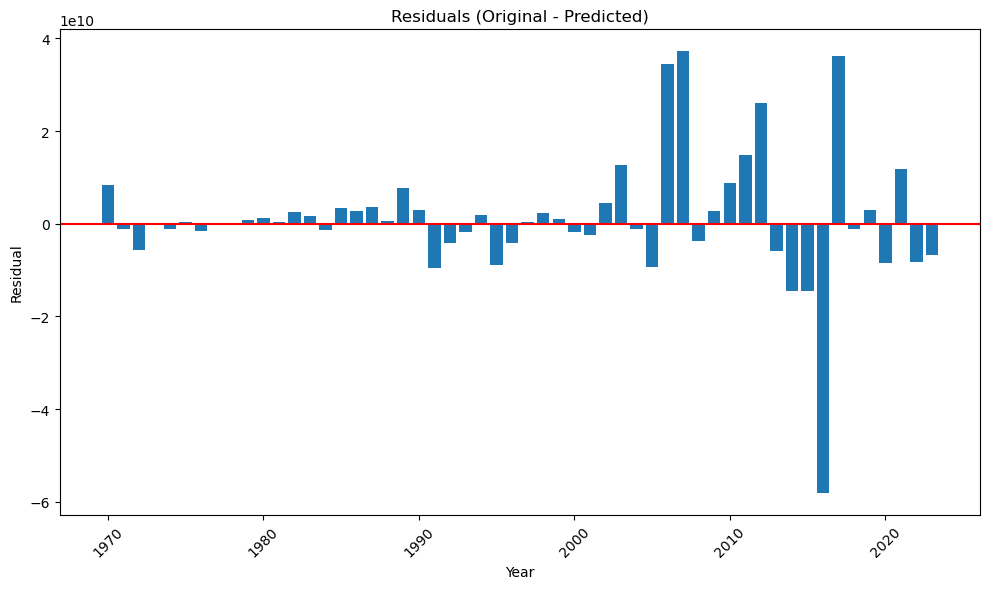

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['year'], result_df['debt'], 'o-', label='Original Debt')
plt.plot(result_df['year'], result_df['Predicted_Debt'], 's--', label='Predicted Debt')
plt.xlabel('Year')
plt.ylabel('Debt')
plt.title('Original vs Predicted Debt Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Plot residuals
plt.figure(figsize=(10, 6))
plt.bar(result_df['year'], result_df['residual'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residuals (Original - Predicted)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

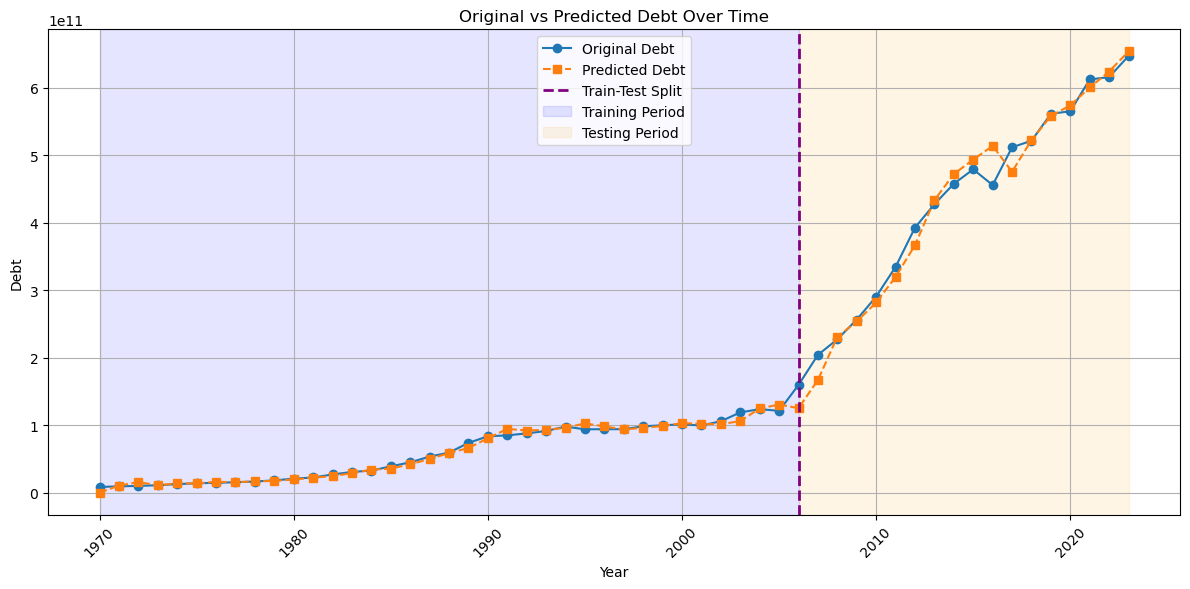

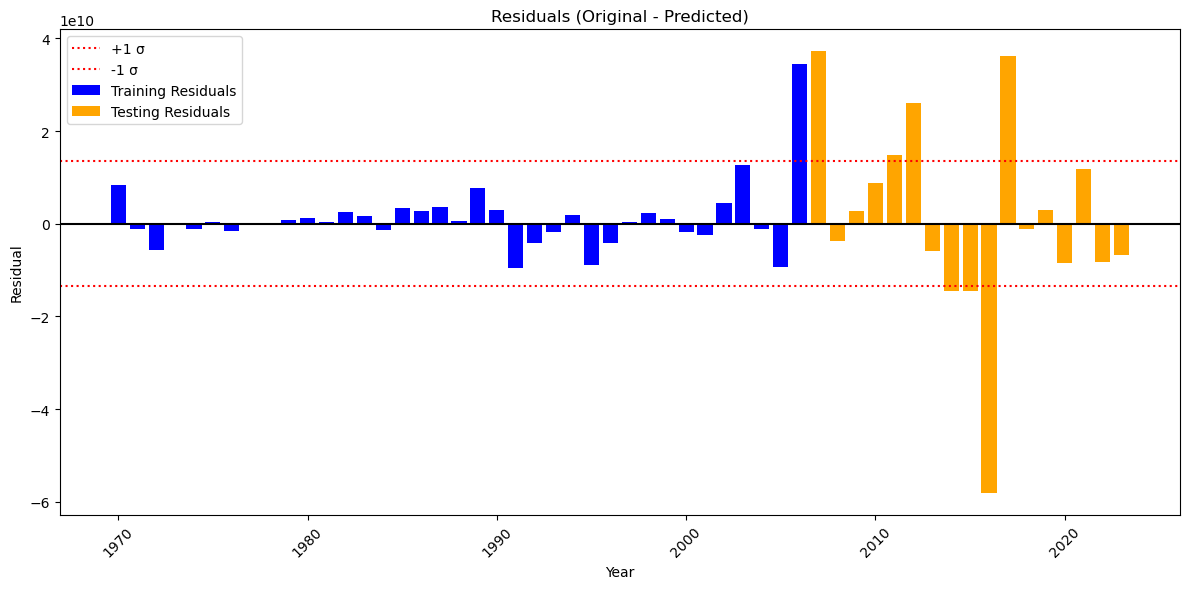

In [46]:
# Find the train-test split point (year)
train_years = result_df.loc[train.index, 'year']
test_years = result_df.loc[test.index, 'year']
split_year = train_years.max()  # The last year in the training set

# First plot: Original vs Predicted with train-test split line
plt.figure(figsize=(12, 6))

# Plot all data
plt.plot(result_df['year'], result_df['debt'], 'o-', label='Original Debt')
plt.plot(result_df['year'], result_df['Predicted_Debt'], 's--', label='Predicted Debt')

# Add vertical line at the train-test split point
plt.axvline(x=split_year, color='purple', linestyle='--', linewidth=2, label='Train-Test Split')

# Shade the training and testing regions
plt.axvspan(result_df['year'].min(), split_year, alpha=0.1, color='blue', label='Training Period')
plt.axvspan(split_year, result_df['year'].max(), alpha=0.1, color='orange', label='Testing Period')

plt.xlabel('Year')
plt.ylabel('Debt')
plt.title('Original vs Predicted Debt Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Second plot: Residuals with different colors for train and test sets but no split line
plt.figure(figsize=(12, 6))

# Create a boolean mask for training and testing points
train_mask = result_df['year'] <= split_year
test_mask = result_df['year'] > split_year

# Plot residuals with different colors
plt.bar(result_df.loc[train_mask, 'year'], result_df.loc[train_mask, 'residual'], 
        color='blue', label='Training Residuals')
plt.bar(result_df.loc[test_mask, 'year'], result_df.loc[test_mask, 'residual'], 
        color='orange', label='Testing Residuals')

# Add the zero line
plt.axhline(y=0, color='black', linestyle='-')

# Add standard deviation lines
std_dev = result_df['residual'].std()
plt.axhline(y=std_dev, color='red', linestyle=':', label='+1 σ')
plt.axhline(y=-std_dev, color='red', linestyle=':', label='-1 σ')

plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residuals (Original - Predicted)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()